In [ ]:
%pip install -U gymnasium
%pip install -U gymnasium[atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.4 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=562b27fe2f68eeeafbbc47f87b4e29b726082aa22c9f876448eabaa9fdd881a5
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gymnasium as gym
import torch.nn.functional as F
import argparse

In [ ]:
env = gym.make('ALE/Pong-v5')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gym.wrappers import AtariPreprocessing
import numpy as np

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(obs, env):
    """Performs necessary observation preprocessing."""
    if env in ['CartPole-v1']:
        return torch.tensor(obs, device=device).float()
    elif env in ['ALE/Pong-v5']:
        return torch.tensor(obs, device=device).float()
    else:
        raise ValueError('Please add necessary observation preprocessing instructions to preprocess() in utils.py.')


In [ ]:
Pong = {
    'Observation_stack_size': 4,
    'memory_size': 10000,
    'n_episodes': 300,
    'batch_size': 32,
    'target_update_frequency': 1000,
    'train_frequency': 4,
    'gamma': 0.99,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'anneal_length': 10**5,
    'n_actions': 6
}
ENV_CONFIGS = {
    'ALE/Pong-v5': Pong
}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (obs, action, next_obs, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample))

device cuda


In [ ]:

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.sigma_init)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.sigma_init)

    def reset_noise(self):
        self.weight_epsilon.data.normal_()
        self.bias_epsilon.data.normal_()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

class DQNAgent(nn.Module):
    def __init__(self, env_config):
        super(DQNAgent, self).__init__()

        # Save hyperparameters needed in the DQNAgent class.
        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]
        self.obs_stack = env_config["Observation_stack_size"]

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = NoisyLinear(3136, 512)
        self.fc2 = NoisyLinear(512, self.n_actions)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.step=0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epsilons = np.linspace(self.eps_start, self.eps_end, self.anneal_length)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def act(self, state, exploit = False):

        epsilon = self.epsilons[min(self.step,self.anneal_length - 1)]
        self.step += 1

        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32, device=self.device)
            q_values = self.forward(state)

            action = torch.argmax(q_values).item()
        return action


    def optimize(self, memory, batch_size, step, dqnagent, target_dqnagent, optimizer, gamma):
        if len(memory) < batch_size:
            return

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        states, actions, next_states, rewards = memory.sample(dqnagent.batch_size)

        states_set = torch.cat(states, dim=0)

        actions_set = torch.LongTensor(actions).unsqueeze(1).to(device)
        next_states = torch.stack(next_states).squeeze(1).squeeze(1)
        next_states_set = torch.tensor(next_states, dtype=torch.float32, device=device)


        rewards_set = torch.tensor(rewards, dtype=torch.float32, device=device)

        q_values = dqnagent(states_set).gather(1, actions_set)

        with torch.no_grad():
          next_q_values = target_dqnagent(next_states_set).max(1).values
        target_q_values = (next_q_values * gamma) + rewards_set

        loss = F.mse_loss(q_values.squeeze(), target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update target network
        if step % env_config['target_update_frequency'] == 0:
            target_dqnagent_state_dict = target_dqnagent.state_dict()
            dqnagent_state_dict = dqnagent.state_dict()
            for i in dqnagent_state_dict:
              target_dqnagent_state_dict[i] = dqnagent_state_dict[i]*0.005 + target_dqnagent_state_dict[i]*(1-0.005)
            target_dqnagent.load_state_dict(target_dqnagent_state_dict)



In [ ]:



if __name__ == '__main__':
  env = gym.make('ALE/Pong-v5')
  env = gym.wrappers.AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30, scale_obs=True)

  env_config = ENV_CONFIGS['ALE/Pong-v5']
  memory = ReplayMemory(env_config['memory_size'])

  dqnagent = DQNAgent(env_config=env_config).to(device)
  target_dqnagent = DQNAgent(env_config=env_config).to(device)
  target_dqnagent.load_state_dict(dqnagent.state_dict())

  #Optimizer for training network
  optimizer = torch.optim.Adam(dqnagent.parameters(), lr=env_config['lr'])

  args = argparse.Namespace(
      env='ALE/Pong-v5',
      evaluate_freq=4,
      evaluation_episodes=100
  )

  final_rewards = []
  trailing_avg_reward = []
  raward_change_freq = 30

  for episode in range(env_config['n_episodes']):
      state, info = env.reset()
      state = preprocess(state, env=args.env).unsqueeze(0)
      total_reward = 0
      step = 0
      terminated = False
      truncated = False

      obs_stack = torch.cat(env_config['Observation_stack_size'] * [state]).unsqueeze(0)

      while not terminated and not truncated:
          action= dqnagent.act(obs_stack)

          next_state, reward, terminated, truncated, info = env.step(action)

          total_reward += reward
          if not terminated and not truncated:
            next_state = preprocess(next_state, env=args.env).unsqueeze(0).clone().detach().to(device)
            obs_stack = obs_stack.to(device)
            next_obs_stack = torch.cat((obs_stack[:, 1:, ...], next_state.unsqueeze(1)), dim=1).to(device)


            memory.push(obs_stack, action, next_obs_stack, reward)
            obs_stack = next_obs_stack


          if step % env_config["train_frequency"] == 0:
            # print('step',step)
            dqnagent.optimize(memory, env_config['batch_size'], step, dqnagent.to(device), target_dqnagent.to(device), optimizer, env_config['gamma'])

      step += 1
      final_rewards.append(total_reward)
      if len(final_rewards)>= 20:
        average = sum(final_rewards[-20:])/20
        trailing_avg_reward.append(average)
      else:
        average = sum(final_rewards)/len(final_rewards)
        trailing_avg_reward.append(average)

      print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Average reward: {average}")


env.close()

<ipython-input-8-518cceba32e6>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device)
<ipython-input-8-518cceba32e6>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states_set = torch.tensor(next_states, dtype=torch.float32, device=device)


Episode: 1, Total Reward: -21.0, Average reward: -21.0
Episode: 2, Total Reward: -20.0, Average reward: -20.5
Episode: 3, Total Reward: -21.0, Average reward: -20.666666666666668
Episode: 4, Total Reward: -20.0, Average reward: -20.5
Episode: 5, Total Reward: -20.0, Average reward: -20.4
Episode: 6, Total Reward: -20.0, Average reward: -20.333333333333332
Episode: 7, Total Reward: -21.0, Average reward: -20.428571428571427
Episode: 8, Total Reward: -21.0, Average reward: -20.5
Episode: 9, Total Reward: -20.0, Average reward: -20.444444444444443
Episode: 10, Total Reward: -21.0, Average reward: -20.5
Episode: 11, Total Reward: -21.0, Average reward: -20.545454545454547
Episode: 12, Total Reward: -20.0, Average reward: -20.5
Episode: 13, Total Reward: -19.0, Average reward: -20.384615384615383
Episode: 14, Total Reward: -21.0, Average reward: -20.428571428571427
Episode: 15, Total Reward: -21.0, Average reward: -20.466666666666665
Episode: 16, Total Reward: -21.0, Average reward: -20.5
E

In [ ]:
import matplotlib.pyplot as plt

257


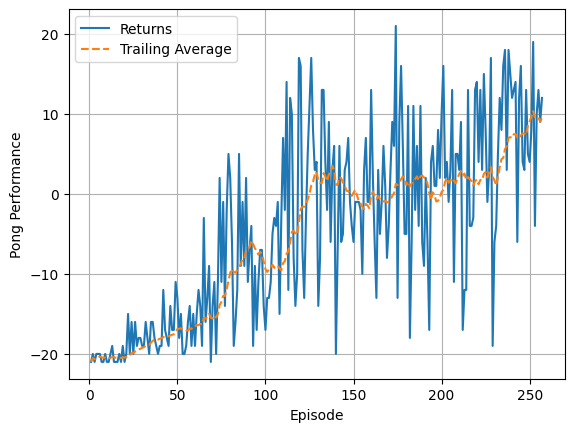

In [ ]:
episodes = list(range(1,258))
print(len(episodes))
plt.plot(episodes,final_rewards[:257],label ="Returns")
plt.plot(episodes, trailing_avg_reward[:257] ,label ="Trailing Average",linestyle="--")
plt.xlabel('Episode')
plt.ylabel("Pong Performance")
plt.legend()
plt.grid(True)
plt.show()